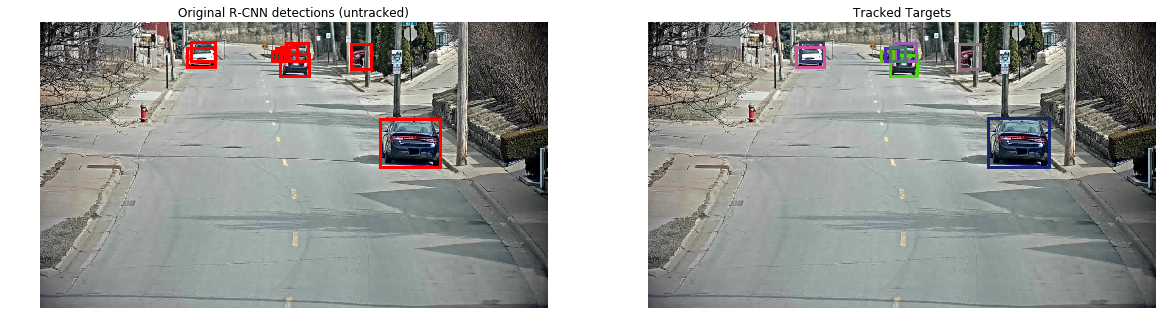

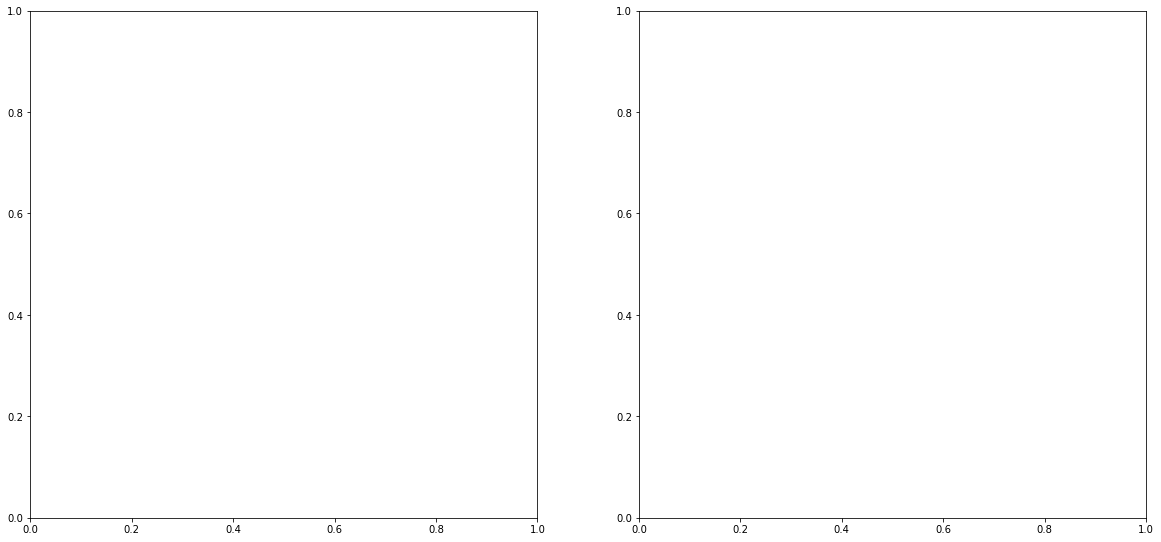

Total Tracking took: 8.960 for 1618 frames or 180.6 FPS


In [4]:
# -*- coding: utf-8 -*-

from __future__ import print_function
%matplotlib inline

import matplotlib
from IPython import display as dp

import numpy as np
from skimage import io
import os
import time

# Standard libraries
import os

# Related 3rd party libraries
import cv2 as cv
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

# Local libraries
import utils as ut
from sort import Sort

#import src

OUTPUT_DIR ='../../../../output'
ROOT_DIR = '../../../../'

# Some constant for the script
TASK = 'task_kalman'
WEEK = 'week3'

# Set useful directories
frames_dir = os.path.join(
    ROOT_DIR,
    'data',
    'm6_week1_frames',
    'frames')

results_dir = os.path.join(OUTPUT_DIR, WEEK, TASK)

# Create folders if they don't exist
if not os.path.isdir(results_dir):
    os.mkdir(results_dir)

# Select input. Options: 'gt_txt', 'gt_xml', 'cnn_out'
INPUT = 'gt_xml'    

# Ground truth file path:

if INPUT == 'gt_txt':
    gt_file = os.path.join(ROOT_DIR,
                           'data', 'AICity_data', 'train', 'S03',
                           'c010', 'gt', 'gt.txt')

elif INPUT == 'gt_xml':
    gt_file_xml = os.path.join(ROOT_DIR,
                           'data', 'AICity_data', 'train', 'S03',
                           'c010', 'gt', 'm6-full_annotation.xml')

# Get BBox detection from list (xml)
df = ut.get_bboxes_from_aicity_file(gt_file_xml)

# Get BBox detection from list (txt)
#df = ut.get_bboxes_from_MOTChallenge(gt_file)

# Adapt GT to final metric calculation (add bbox and track_id columns):
df.loc[:,'track_id'] = df['id'].values.tolist()

boxes = []
for index, row in df.iterrows():
    #boxes.append([row['ytl'], row['xtl'], row['ybr'], row['xbr']])
    boxes.append([row['xtl'], row['ytl'], row['xbr'], row['ybr']])

df['boxes'] = boxes


# Sort and group bbox by frame
df.sort_values(by=['frame'])
df_grouped = df.groupby('frame')

vals = list()

# Display data:

colours = np.random.rand(32,3) # Used only for display

# Run tracker:

display = True
save = True
total_time = 0.0
total_frames = 0
out = []

if display:
    plt.ion()  # for iterative display
    fig, ax = plt.subplots(1, 2, figsize=(20, 20))

mot_tracker = Sort()  # create instance of the SORT tracker

for f, df_group in df_grouped:
    
    frame = int(df_group['frame'].values[0])

    # GT xml:
    df_gt = df_group[['ytl', 'xtl', 'ybr', 'xbr']].values.tolist()
    # GT txt:
    #df_gt = df_group[['ymin', 'xmin', 'ymax', 'xmax']].values.tolist()
    df_gt = np.asarray(df_gt)

    dets = np.stack([df_gt[:,1], df_gt[:,0], df_gt[:,3], df_gt[:,2]], axis=1)
  
    dets = np.reshape(dets, (len(dets), -1))
    
    dets = np.asarray(dets, dtype=np.float64, order='C')

    if (display):
        fn = '../../../../frames/frame_%03d.jpg' % (frame)  # read the frame
        im = io.imread(fn)
        
        video_name = 'video_kalman.avi'
        height, width, layers = im.shape
        video = cv.VideoWriter(video_name, 0, 1, (width,height))
        
        ax[0].imshow(im)
        ax[0].axis('off')
        ax[0].set_title('Original R-CNN detections (untracked)')
        for j in range(np.shape(dets)[0]):
            color = 'r'
            coords = (dets[j, 0].astype(np.float), dets[j, 1].astype(np.float)), dets[j, 2].astype(np.float) - dets[j, 0].astype(np.float), dets[j, 3].astype(np.float) - dets[j, 1].astype(np.float)
            ax[0].add_patch(plt.Rectangle(*coords, fill=False, edgecolor=color, lw=3))

    total_frames += 1
    
    if (display):
        ax[1].imshow(im)
        ax[1].axis('off')
        ax[1].set_title('Tracked Targets')

    start_time = time.time()
    trackers = mot_tracker.update(dets)
    cycle_time = time.time() - start_time
    total_time += cycle_time

    out.append([frame, trackers])

    for d in trackers:
        if (display):
            d = d.astype(np.uint32)
            ax[1].add_patch(
                patches.Rectangle((d[0], d[1]), d[2] - d[0], d[3] - d[1], fill=False, lw=3, ec=colours[d[4] % 32, :]))
            ax[1].set_adjustable('box-forced')
    
    if (save):
        plt.savefig(os.path.join(results_dir, 'video_kalman_xml_' + str(frame) + '.png'))

    if (display):
        dp.clear_output(wait=True)
        dp.display(plt.gcf())
        time.sleep(0.000001)
        ax[0].cla()
        ax[1].cla()

plt.show()

print("Total Tracking took: %.3f for %d frames or %.1f FPS" % (total_time, total_frames, total_frames / total_time))


Transform output to pandas format:

In [5]:
import pandas as pd

def locate_panda_feature(pd_dataframe, key, value):
    """
    Group pandas dataframe by selected key
    """
    grouped_pd = pd_dataframe.groupby(key).agg(lambda x: list(x))
    
    return grouped_pd.loc[value]


#locate_panda_feature(df_kalman, 'img_id', 425)

#####################################################################

def kalman_out_to_pandas(out_kalman):
    
    """
    :param out_kalman: Output from kalman tracking
    :returns: Panda dataframe with format 'frame', 'ymin', 'xmin', 'ymax', 'xmax', 'track_id'
    """

    vals = list()

    for frame_data in out_kalman:

        frame = frame_data[0]
        frame_vals = [frame]

        for track in frame_data[1]:

            ymin, xmin, ymax, xmax, track_id = track
            
            #score = 1
            score = np.random.uniform(0,1)
            
            frame_vals = [frame, ymin, xmin, ymax, xmax, track_id, score]

            vals.append(frame_vals)

    df_kalman = pd.DataFrame(vals, columns=['frame', 'ymin', 'xmin', 'ymax', 'xmax', 'track_id', 'score'])
    
    return df_kalman

df_kalman = kalman_out_to_pandas(out)

###################################################

def kalman_out_to_pandas_for_map(out_kalman):
    
    """
    Prepair dictionary for map_metrics.py
    :param out_kalman: Output from kalman tracking
    :returns: Panda dataframe with format 'img_id', 'boxes', 'track_id', 'scores'
    """

    vals = list()

    for frame_data in out_kalman:

        img_id = frame_data[0]
        frame_vals = [frame]

        for track in frame_data[1]:
                       
            xmin, ymin, xmax, ymax, track_id = track
            
            #ymin, xmin, ymax, xmax, track_id = track
            
            boxes = [xmin, ymin, xmax, ymax]
            
            scores = np.random.uniform(low=0.8, high=1.0)

            frame_vals = [img_id, boxes, track_id, scores]

            vals.append(frame_vals)

    df_kalman = pd.DataFrame(vals, columns=['img_id', 'boxes', 'track_id', 'scores'])
    
    return df_kalman


###################################################

def kalman_out_to_pandas_for_map2(out_kalman):
    
    """
    Prepair dictionary for map_metrics.py
    :param out_kalman: Output from kalman tracking
    :returns: Panda dataframe with format 'img_id', 'boxes', 'track_id', 'scores'
    """

    vals = list()

    for frame_data in out_kalman:

        img_id = frame_data[0]
        frame_vals = [frame]
        
        boxes = []
        
        for track in frame_data[1]:

            ymin, xmin, ymax, xmax, track_id = track
            
            boxes.append([xmin, ymin, xmax, ymax])
            
            scores = np.random.uniform(low=0.8, high=1.0)

        frame_vals = [img_id, boxes, track_id, scores]

        vals.append(frame_vals)

    df_kalman = pd.DataFrame(vals, columns=['img_id', 'boxes', 'track_id', 'scores'])
    
    return df_kalman

###########################################################

def get_bboxes_from_MOTChallenge_for_map(fname):
    """
    Read GT as format required in map_metrics.py
    
    Get the Bboxes from the txt files
    MOTChallengr format [frame,ID,left,top,width,height,1,-1,-1,-1]
     {'ymax': 84.0, 'frame': 90, 'track_id': 2, 'xmax': 672.0, 'xmin': 578.0, 'ymin': 43.0, 'occlusion': 1}
    fname: is the path to the txt file
    :returns: Pandas DataFrame with the data
    """
    f = open(fname,"r")
    BBox_list = list()

    for line in f:
        data = line.split(',')
        xmax = float(data[2])+float(data[4])
        ymax = float(data[3])+float(data[5])
        
        BBox_list.append({'img_id':int(data[0]),
                          'track_id':int(data[1]),
                          'boxes': [float(data[2]), float(data[3]), xmax, ymax],
                          'occlusion': 1,
                          'conf' :float(data[6])})
        
    return pd.DataFrame(BBox_list)


###########################################################

def get_bboxes_from_xml_for_map(gt_panda):

    """
    Prepair dictionary for map_metrics.py
    :param out_kalman: Output from kalman tracking
    :returns: Panda dataframe with format 'img_id', 'boxes', 'track_id'
    """

    vals = list()

    for frame_data in gt_panda:

        img_id = frame_data[0]
        frame_vals = [frame]
        
        boxes = []
        
        for track in frame_data[1]:
            
            ymin, xmin, ymax, xmax, track_id = track
            
            boxes.append([xmin, ymin, xmax, ymax])
            
            scores = np.random.uniform(low=0.8, high=1.0)

        frame_vals = [img_id, boxes, track_id, scores]

        vals.append(frame_vals)

    df_kalman = pd.DataFrame(vals, columns=['img_id', 'boxes', 'track_id', 'scores'])
    
    return df_kalman




# map metrics: xmin, ymin, xmax, ymax

In [4]:
df.loc[:,'img_id'] = df['frame'].values.tolist()


In [8]:
df_kalman.to_pickle('kalman_out_from_xml.pkl')

df_gt_xml.to_pickle('gt_xml_panda.pkl')

Attempts for transforming pandas into map_function input:

In [6]:
import map_metrics as mp

df_kalman = kalman_out_to_pandas_for_map(out)

df_gt = get_bboxes_from_MOTChallenge_for_map(gt_file)

df_gt_xml = df



In [6]:
import json

d_pred = {}
for name , group in df_kalman.groupby('img_id'):
    boxes = []
    scores = []
    for idx in range(len(group)):
        boxes.append(group.iloc[idx].boxes)
        
        scores.append(group.iloc[idx].scores)
    d_pred[group.iloc[idx].img_id] = {'boxes': boxes, 'scores':scores}
    
d_gt = {}
for name , group in df_gt_xml.groupby('img_id'):
    boxes = []
    for idx in range(len(group)):
        boxes.append(group.iloc[idx].boxes)
    d_gt[group.iloc[idx].img_id] = {'boxes': boxes}

with open('ground_truth_boxes.json', 'w') as fp:
    json.dump(d_gt, fp)
    

with open('predicted_boxes.json', 'w') as fpp:
    json.dump(d_pred, fpp)

In [20]:
#def get_model_scores_map(pred_boxes):
    

model_scores_map = {}
for f, df_group in kalman_group:
    img_id = f
    boxes = kalman_group['boxes'].values#.tolist()
    scores = kalman_group['score'].values#.tolist()
    #for img_id, val in pred_boxes.items():
    for score in scores:
        if score not in model_scores_map.keys():
            model_scores_map[score] = [img_id]
        else:
            model_scores_map[score].append(img_id)
#return model_scores_map


AttributeError: Cannot access attribute 'values' of 'SeriesGroupBy' objects, try using the 'apply' method

In [ ]:
df_kalman = kalman_out_to_pandas_for_map(out)

d = dict()
for idx, el in df_kalman.iterrows():
    try:
        d[el.img_id].append(el.boxes)
        d[el.img_id].append(el.scores)
    except:
        d[el.img_id] = [el.boxes]


#df_kalman_new = df_kalman_new.set_index('img_id')
#df_gt_new = df_gt.set_index('img_id')

df_kalman_new.to_json('kalman_dataframe_new.json', orient='index')

df_gt_new.to_json('gt_dataframe_new.json', orient='index')


In [22]:
df_kalman_new = kalman_out_to_pandas_for_map2(out)

df_kalman_new = df_kalman_new.set_index('img_id')
df_gt_new = df_gt.set_index('img_id')

df_kalman_new.to_json('predicted_boxes.json', orient='index')

df_gt_new.to_json('ground_truth_boxes.json', orient='index')

ValueError: DataFrame index must be unique for orient='index'.